This notebook conducts a comparison and validation analysis between Plant Area Index (PAI) data from NASA's Global Ecosystem Dynamics Investigation (GEDI) mission and PAI data derived from high-resolution aerial lidar. The primary goal is to assess how well GEDI's PAI measurements align with a ground-truth or higher-resolution reference dataset over the Sewanee Domain.
The overall workflow involves these key steps:
1. Environment Setup: The notebook prepares the working environment by mounting Google Drive for persistent storage and installing all required Python libraries for geospatial analysis, such as geopandas, rasterio, and rasterstats.
2. Data Acquisition: It automatically downloads the necessary datasets from a Zenodo repository, which includes a filtered GEDI L2B data file in CSV format and a high-resolution PAI GeoTIFF file derived from lidar.
3. Data Processing: The GEDI data, which consists of individual footprint locations (points), is loaded and processed. Circular plots with a 25-meter diameter are created around each GEDI footprint location to represent the area of each observation.
4. Data Integration: Using a technique called zonal statistics, the notebook calculates the average high-resolution PAI value from the GeoTIFF file within each of the 25-meter GEDI plots. This allows for a direct comparison between the two different data sources.
5. Analysis and Visualization: Finally, the notebook statistically compares the GEDI PAI values with the averaged lidar PAI values. It generates a scatter plot, performs a linear regression, and calculates key metrics like the R-squared value, correlation, and the equation of the trend line to quantify the relationship between the two datasets.

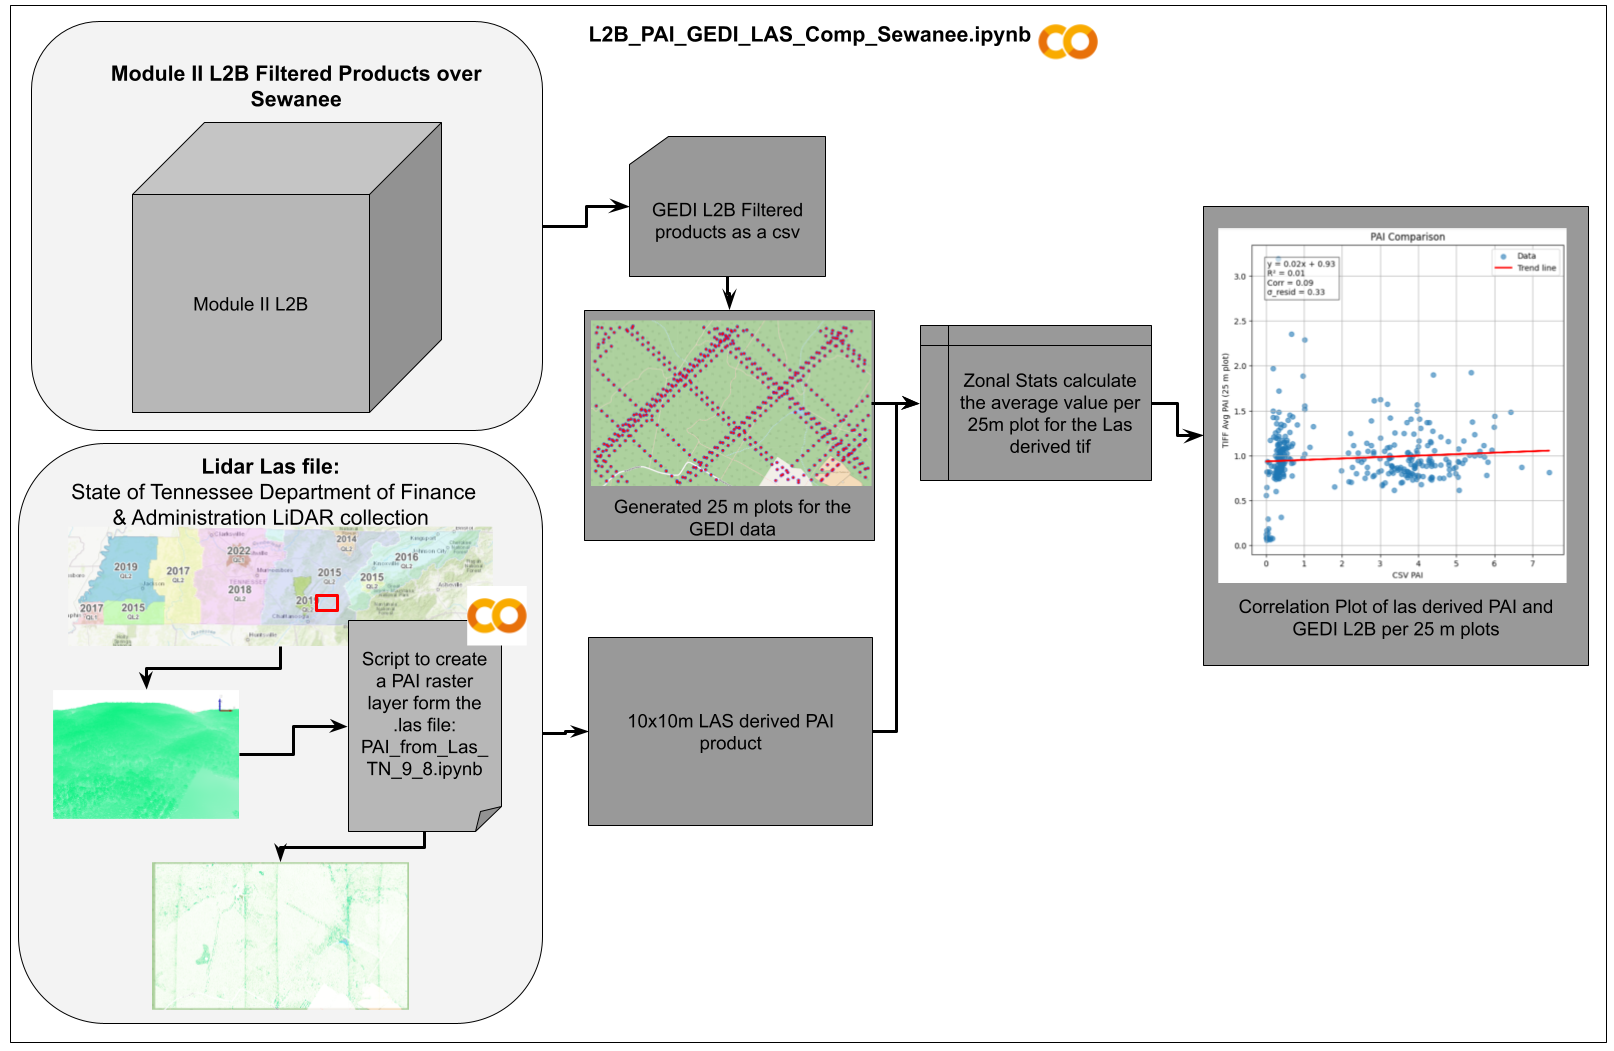

Contact Info
Email: timothy.j.mayer@nasa.gov

Organization: EarthRISE

Website: https://uah-lab-for-applied-science.github.io/Getting_started_with_GEDI_lidar_training/

For additional scientific background, examples, and resources on GEDI and its applications: https://servir.github.io/GEDI_Earthhub_ARSET_Training/

Date last modified: 09-16-2025

Funding for this work was provided through the cooperative agreement 80MSFC22N0004 between NASA and UAH. SERVIR is a joint NASA- and USAID-led program.

# Prep Working Folders

Note these files and processsing efforts are "heavy". So we are using GDrive instead of the temp Colab space. This is to help with checkpoints in files. If the ram crashes the expored files can be grabbed form GDrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pwd

/content


In [ ]:
!mkdir /content/drive/MyDrive/GEDI_LAS_Comp

In [ ]:
%cd /content/drive/MyDrive/GEDI_LAS_Comp

/content/drive/MyDrive/GEDI_LAS_Comp


In [ ]:
!pwd

/content/drive/MyDrive/GEDI_LAS_Comp


In [ ]:
path = "/content/drive/MyDrive/GEDI_LAS_Comp"

# Environment Set-up

Single command to set-up our working environment

In [ ]:
!pip install laspy pyproj open3d plotly rasterio rasterstats shapely matplotlib folium geopandas

In [ ]:
import laspy
from pyproj import CRS
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
import glob
import shutil
import plotly.graph_objects as go
import pandas as pd
import glob
from shapely.geometry import Point
import geopandas as gpd

# Fetch and Derived PAI

This block of code automates the data download process. It uses the Zenodo API to fetch all files from a specific record (ID 17079144).

See the ipynb that take the ALS Lidar and compute the pai and export the layer as 10m resolution tif which is staged in the zenodo

### Theory used in the other notebook to estimate Plant Area Index (PAI) employing gap fraction

Using **gap fraction theory**, the **Plant Area Index (PAI)** is estimated by relating the probability of seeing a gap in the canopy \${P_{\text{gap}}}$ to the amount of vegetation present. The **Beer-Lambert law**, which describes the exponential attenuation of light through a medium, is adapted to model how plant canopies intercept light.

The formula is:

$$
\mathrm{PAI} = - \frac{1}{\Omega} \ln(P_{\text{gap}})
$$

#### Definition of Variables

- **PAI (Plant Area Index):**  
  Defined as half of the total area of all plant surfaces—including leaves, stems, and branches—per unit of horizontal ground area \${m^{2}/m^{2}}$. It is a key metric for understanding the **density and structure of vegetation**.

- **\${P_{\text{gap}}}$ (Gap Fraction):**  
  The probability that a photon of light, traveling in a specific direction (view zenith angle), passes unobstructed through the canopy. It is measured using optical instruments, such as **hemispherical photography**, that record the ratio of sky to vegetation in an image.

- **\${\Omega}$ (Clumping Index):**  
  A correction factor that accounts for the **non-random distribution of plant elements** in a canopy. While the basic Beer-Lambert law assumes a random distribution of foliage, most real canopies are "clumped" (e.g., leaves clustered on branches within tree crowns).  
  - < 1 indicates a **clumped canopy**, increasing the gap fraction compared to a random canopy of the same density.  
  - 1 assumes a **random distribution** of foliage.


[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.17079144.svg)](https://doi.org/10.5281/zenodo.17079144)

In [ ]:
import requests
import os
import zipfile
from google.colab import drive



# . Set target folder
target_dir = "/content/drive/MyDrive/GEDI_LAS_Comp"
os.makedirs(target_dir, exist_ok=True)

# . Zenodo record ID
record_id = "17079144"

# . Fetch record metadata
r = requests.get(f"https://zenodo.org/api/records/{record_id}")
r.raise_for_status()
files = r.json()['files']

# . Download each file
for file_info in files:
    filename = file_info['key']
    download_url = file_info['links']['self']
    file_path = os.path.join(target_dir, filename)

    print(f"Downloading {filename} ...")
    with requests.get(download_url, stream=True) as r_file:
        r_file.raise_for_status()
        with open(file_path, 'wb') as f:
            for chunk in r_file.iter_content(chunk_size=8192):
                f.write(chunk)
    print(f"Downloaded: {filename}")

    # 6. If ZIP file, extract it
    if filename.endswith(".zip"):
        print(f"Extracting {filename} ...")
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall(target_dir)
        print(f"Extraction completed for {filename}")


Csv from the prior module as a checkpoint

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Load CSV
csv_path = '/content/drive/MyDrive/GEDI_LAS_Comp/Sewanee_Domain_GEDI02_B_GEDI02_B_filt.csv'
df = pd.read_csv(csv_path, sep=',')  # tab-separated based on your example

# Create GeoDataFrame from lat/lon
gdf = gpd.GeoDataFrame(df,
                       geometry=gpd.points_from_xy(df['lon'], df['lat']),
                       crs='EPSG:4326')  # WGS84


In [ ]:
gdf

,lat,lon,geolocation/solar_elevation,geolocation/local_beam_elevation,selected_l2a_algorithm,geolocation/degrade_flag,l2b_quality_flag,geolocation/digital_elevation_model,geolocation/elev_lowestmode,geolocation/elev_highestreturn,...,pavd_z,cover,cover_z,product,Beam,fileName,date,Beam_Type,AOI,geometry
0,35.230753,-85.989273,6.302411,1.496346,2,0,1,488.595062,469.876038,498.688507,...,"[0.23534557223320007, 0.2009992003440857, 0.17...",0.890477,"[0.8903491497039795, 0.804418683052063, 0.7044...",GEDI_L2B,BEAM0010,GEDI02_B_2024169103448_O31228_02_T05264_02_004...,2024-06-17,Coverage,Sewanee_Domain_GEDI02_B,POINT (-85.98927 35.23075)
1,35.231110,-85.988802,6.302933,1.496346,2,0,1,488.595062,487.756012,513.952576,...,"[0.22372138500213623, 0.2380671203136444, 0.24...",0.908667,"[0.9086666107177734, 0.84205162525177, 0.70505...",GEDI_L2B,BEAM0010,GEDI02_B_2024169103448_O31228_02_T05264_02_004...,2024-06-17,Coverage,Sewanee_Domain_GEDI02_B,POINT (-85.9888 35.23111)
2,35.231465,-85.988333,6.303455,1.496347,2,0,1,518.880188,500.006073,528.669067,...,"[0.10372597724199295, 0.13118664920330048, 0.1...",0.899972,"[0.899565577507019, 0.8705615997314453, 0.8086...",GEDI_L2B,BEAM0010,GEDI02_B_2024169103448_O31228_02_T05264_02_004...,2024-06-17,Coverage,Sewanee_Domain_GEDI02_B,POINT (-85.98833 35.23147)
3,35.231823,-85.987862,6.303974,1.496347,2,0,1,528.466675,517.767456,538.321106,...,"[0.19986823201179504, 0.2467811554670334, 0.31...",0.908139,"[0.9079335927963257, 0.8498492240905762, 0.689...",GEDI_L2B,BEAM0010,GEDI02_B_2024169103448_O31228_02_T05264_02_004...,2024-06-17,Coverage,Sewanee_Domain_GEDI02_B,POINT (-85.98786 35.23182)
4,35.232178,-85.987394,6.304492,1.496347,2,0,1,533.974304,529.207642,548.079651,...,"[0.20133158564567566, 0.24455709755420685, 0.2...",0.847069,"[0.8462313413619995, 0.7470957040786743, 0.482...",GEDI_L2B,BEAM0010,GEDI02_B_2024169103448_O31228_02_T05264_02_004...,2024-06-17,Coverage,Sewanee_Domain_GEDI02_B,POINT (-85.98739 35.23218)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11606,35.169725,-85.859239,8.667745,1.543402,2,0,1,534.340332,516.074463,546.895935,...,"[0.049275320023298264, 0.09354183822870255, 0....",0.866127,"[0.8661274313926697, 0.848619282245636, 0.7864...",GEDI_L2B,BEAM1011,GEDI02_B_2022289120454_O21768_02_T09533_02_003...,2022-10-16,Power,Sewanee_Domain_GEDI02_B,POINT (-85.85924 35.16973)
11607,35.170074,-85.858778,8.668024,1.543402,2,0,1,534.340332,517.672363,547.819702,...,"[0.05718633532524109, 0.08482596278190613, 0.1...",0.857450,"[0.8574496507644653, 0.8355898857116699, 0.782...",GEDI_L2B,BEAM1011,GEDI02_B_2022289120454_O21768_02_T09533_02_003...,2022-10-16,Power,Sewanee_Domain_GEDI02_B,POINT (-85.85878 35.17007)
11608,35.170425,-85.858316,8.668304,1.543402,2,0,1,541.804138,529.444031,550.640869,...,"[0.02774546854197979, 0.06042185425758362, 0.1...",0.717542,"[0.7175419330596924, 0.6972731947898865, 0.618...",GEDI_L2B,BEAM1011,GEDI02_B_2022289120454_O21768_02_T09533_02_003...,2022-10-16,Power,Sewanee_Domain_GEDI02_B,POINT (-85.85832 35.17042)
11609,35.170774,-85.857855,8.668584,1.543402,2,0,1,539.671265,531.997742,552.820007,...,"[0.04797375574707985, 0.07368183135986328, 0.1...",0.613093,"[0.613092839717865, 0.5638202428817749, 0.4408...",GEDI_L2B,BEAM1011,GEDI02_B_2022289120454_O21768_02_T09533_02_003...,2022-10-16,Power,Sewanee_Domain_GEDI02_B,POINT (-85.85785 35.17077)


In [ ]:
# Reproject to TIFF CRS
tif_crs = 'EPSG:6576'
gdf_proj = gdf.to_crs(tif_crs)


# Create 25 Plots to match the GEDI observations

This line creates a circular plot around each GEDI point. Although the comment mentions a "25m radius square," the .buffer() function with a single argument creates a circle. The radius is set to 12.5 units of the CRS (feet), which is different from the 25-meter diameter goal mentioned in the comment. The comment correctly notes that a 25-meter buffer would be approximately 41 feet in radius (82/2)

In [ ]:
# Create 25m radius square (12.5 m buffer in each direction)
gdf_proj['plot'] = gdf_proj.geometry.buffer(12.5)  # buffer in units of CRS (ft)
# Note: 1 ft ≈ 0.3048 m, so 25 m ≈ 82 ft
# Adjust buffer if you want exactly 25 m in projected CRS:
gdf_proj['plot'] = gdf_proj.geometry.buffer(82/2)  # 82 ft ~ 25 m


In [ ]:
gdf_proj

,lat,lon,geolocation/solar_elevation,geolocation/local_beam_elevation,selected_l2a_algorithm,geolocation/degrade_flag,l2b_quality_flag,geolocation/digital_elevation_model,geolocation/elev_lowestmode,geolocation/elev_highestreturn,...,cover,cover_z,product,Beam,fileName,date,Beam_Type,AOI,geometry,plot
0,35.230753,-85.989273,6.302411,1.496346,2,0,1,488.595062,469.876038,498.688507,...,0.890477,"[0.8903491497039795, 0.804418683052063, 0.7044...",GEDI_L2B,BEAM0010,GEDI02_B_2024169103448_O31228_02_T05264_02_004...,2024-06-17,Coverage,Sewanee_Domain_GEDI02_B,POINT (1971703.649 326669.951),"POLYGON ((1971744.649 326669.951, 1971744.452 ..."
1,35.231110,-85.988802,6.302933,1.496346,2,0,1,488.595062,487.756012,513.952576,...,0.908667,"[0.9086666107177734, 0.84205162525177, 0.70505...",GEDI_L2B,BEAM0010,GEDI02_B_2024169103448_O31228_02_T05264_02_004...,2024-06-17,Coverage,Sewanee_Domain_GEDI02_B,POINT (1971844.498 326800.161),"POLYGON ((1971885.498 326800.161, 1971885.3 32..."
2,35.231465,-85.988333,6.303455,1.496347,2,0,1,518.880188,500.006073,528.669067,...,0.899972,"[0.899565577507019, 0.8705615997314453, 0.8086...",GEDI_L2B,BEAM0010,GEDI02_B_2024169103448_O31228_02_T05264_02_004...,2024-06-17,Coverage,Sewanee_Domain_GEDI02_B,POINT (1971984.314 326929.44),"POLYGON ((1972025.314 326929.44, 1972025.116 3..."
3,35.231823,-85.987862,6.303974,1.496347,2,0,1,528.466675,517.767456,538.321106,...,0.908139,"[0.9079335927963257, 0.8498492240905762, 0.689...",GEDI_L2B,BEAM0010,GEDI02_B_2024169103448_O31228_02_T05264_02_004...,2024-06-17,Coverage,Sewanee_Domain_GEDI02_B,POINT (1972125.141 327059.59),"POLYGON ((1972166.141 327059.59, 1972165.943 3..."
4,35.232178,-85.987394,6.304492,1.496347,2,0,1,533.974304,529.207642,548.079651,...,0.847069,"[0.8462313413619995, 0.7470957040786743, 0.482...",GEDI_L2B,BEAM0010,GEDI02_B_2024169103448_O31228_02_T05264_02_004...,2024-06-17,Coverage,Sewanee_Domain_GEDI02_B,POINT (1972264.807 327188.698),"POLYGON ((1972305.807 327188.698, 1972305.61 3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11606,35.169725,-85.859239,8.667745,1.543402,2,0,1,534.340332,516.074463,546.895935,...,0.866127,"[0.8661274313926697, 0.848619282245636, 0.7864...",GEDI_L2B,BEAM1011,GEDI02_B_2022289120454_O21768_02_T09533_02_003...,2022-10-16,Power,Sewanee_Domain_GEDI02_B,POINT (2010571.482 304486.462),"POLYGON ((2010612.482 304486.462, 2010612.285 ..."
11607,35.170074,-85.858778,8.668024,1.543402,2,0,1,534.340332,517.672363,547.819702,...,0.857450,"[0.8574496507644653, 0.8355898857116699, 0.782...",GEDI_L2B,BEAM1011,GEDI02_B_2022289120454_O21768_02_T09533_02_003...,2022-10-16,Power,Sewanee_Domain_GEDI02_B,POINT (2010708.998 304613.629),"POLYGON ((2010749.998 304613.629, 2010749.8 30..."
11608,35.170425,-85.858316,8.668304,1.543402,2,0,1,541.804138,529.444031,550.640869,...,0.717542,"[0.7175419330596924, 0.6972731947898865, 0.618...",GEDI_L2B,BEAM1011,GEDI02_B_2022289120454_O21768_02_T09533_02_003...,2022-10-16,Power,Sewanee_Domain_GEDI02_B,POINT (2010847.092 304741.524),"POLYGON ((2010888.092 304741.524, 2010887.895 ..."
11609,35.170774,-85.857855,8.668584,1.543402,2,0,1,539.671265,531.997742,552.820007,...,0.613093,"[0.613092839717865, 0.5638202428817749, 0.4408...",GEDI_L2B,BEAM1011,GEDI02_B_2022289120454_O21768_02_T09533_02_003...,2022-10-16,Power,Sewanee_Domain_GEDI02_B,POINT (2010984.665 304868.798),"POLYGON ((2011025.665 304868.798, 2011025.468 ..."


#Zonal Stats avergaing the 10m Las pai to the 25m GEDI plots

This is a critical data integration step. The zonal_stats function is used to calculate the mean PAI value from the high-resolution GeoTIFF (1982317NW_PAI_10m_9_8.tif) for the area covered by each GEDI plot polygon. The calculated mean value for each plot is then stored in a new column named avg_las_pai in the GeoDataFrame. Any rows with missing data in either the GEDI 'pai' column or the new 'avg_las_pai' column are dropped to ensure a clean comparison

In [ ]:
import rasterio
from rasterstats import zonal_stats

tif_path = '/content/drive/MyDrive/GEDI_LAS_Comp/1982317NW_PAI_10m_9_8.tif'

# Calculate zonal stats
stats = zonal_stats(gdf_proj['plot'], tif_path, stats=['mean'], nodata=-9999)
gdf_proj['avg_las_pai'] = [s['mean'] for s in stats]


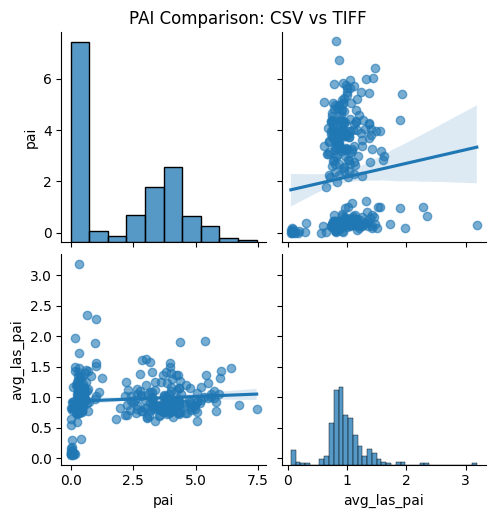

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop rows with NaN in either column
df_plot = gdf_proj.dropna(subset=['pai', 'avg_las_pai'])

# Select only the two columns
df_plot = df_plot[['pai', 'avg_las_pai']]

# Pair plot
sns.pairplot(df_plot, kind='reg', plot_kws={'scatter_kws': {'alpha':0.6}})
plt.suptitle('PAI Comparison: CSV vs TIFF', y=1.02)
plt.show()


### GEDI vs. Lidar PAI Comparison Scatter Plot

The final cell of the notebook is dedicated to creating a **comprehensive scatter plot** that visually and statistically compares the **Plant Area Index (PAI)** from GEDI against the PAI derived from high-resolution aerial lidar. This plot serves as the primary output for validating the GEDI data against the reference lidar data.

- **Axes and Data Representation:**
  - The **x-axis** represents the GEDI PAI values, sourced from the `pai` column of the processed GeoDataFrame. This data comes from the original filtered CSV file.
  - The **y-axis** represents the average PAI from the lidar data, sourced from the `avg_las_pai` column. This value was calculated for each GEDI footprint by averaging the pixels from the high-resolution PAI GeoTIFF that fell within the 25-meter plot area around each GEDI point.

Note the correlation is lower than what might be expected after the significant level of quality filtering that occurring in the prior module.  But keep in mind this is just a demonstration to show how GEDI can be intercompared with ALS type products.

Known caveats to communicate with this analysis is that the ALS lidar used is from 2015 and the time period for capture was over multiple dates. So, this inherently a less effective direct comparison as the dates between observations varies greatly.  Additionally, the derived PAI is computed to a 10m resolution, more clear justification for this nominal scale is provided in the additional notebook. However, different ALS LiDAR or TLS sources could enable finer resolution, in future analyses. And it could be suspected that this will likely improve the correlation between GEID and ALS/TLS products.

In conclusion, exhaustive filtering is need for GEDI use, but similar level of scrutiny should be applied to other products as well when constructing these comparative analyses.


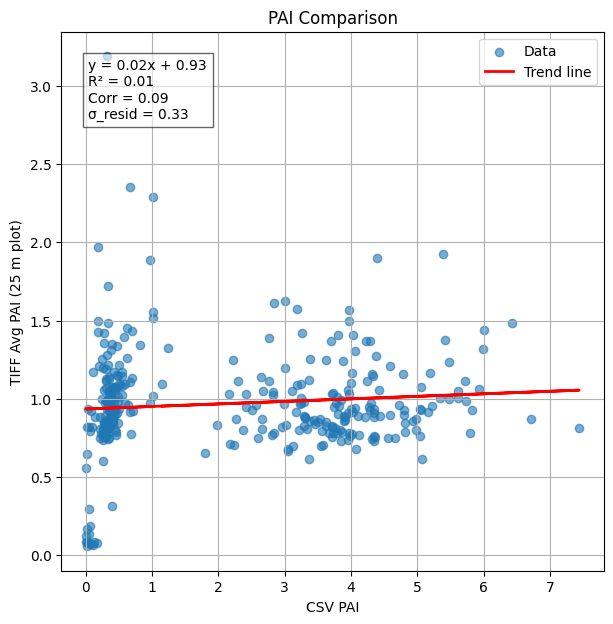

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Drop any NaNs
df_corr = gdf_proj.dropna(subset=['pai', 'avg_las_pai'])

# Extract x and y
x = df_corr['pai'].values.reshape(-1, 1)
y = df_corr['avg_las_pai'].values

# Linear regression
reg = LinearRegression().fit(x, y)
y_pred = reg.predict(x)

# Compute R^2
r2 = reg.score(x, y)

# Compute standard deviation of residuals
residuals = y - y_pred
std_resid = np.std(residuals)

# Correlation
corr = np.corrcoef(df_corr['pai'], df_corr['avg_las_pai'])[0,1]

# Scatter plot with trend line
plt.figure(figsize=(7,7))
plt.scatter(x, y, alpha=0.6, label='Data')
plt.plot(x, y_pred, color='red', linewidth=2, label='Trend line')
plt.xlabel('CSV PAI')
plt.ylabel('TIFF Avg PAI (25 m plot)')
plt.title('PAI Comparison')

# Add equation and metrics on plot
eq_text = f'y = {reg.coef_[0]:.2f}x + {reg.intercept_:.2f}\nR² = {r2:.2f}\nCorr = {corr:.2f}\nσ_resid = {std_resid:.2f}'
plt.text(0.05, 0.95, eq_text, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.6))

plt.grid(True)
plt.legend()
plt.show()


Contact Info
Email: timothy.j.mayer@nasa.gov

Organization: EarthRISE

Website: https://uah-lab-for-applied-science.github.io/Getting_started_with_GEDI_lidar_training/

For additional scientific background, examples, and resources on GEDI and its applications: https://servir.github.io/GEDI_Earthhub_ARSET_Training/

Date last modified: 09-16-2025

Funding for this work was provided through the cooperative agreement 80MSFC22N0004 between NASA and UAH. SERVIR is a joint NASA- and USAID-led program.